In [55]:
# Import necessary libraries
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# Load the data
df = pd.read_csv('Combined_Secondary_Defense.csv')
metric = 'Current_PFF'  # Metric to predict

In [57]:
print(df.columns)

Index(['Unnamed: 0', 'Team', 'Year', 'Position', 'Value_cap_space',
       'Value_draft_data', 'Current_AV', 'Current_PFF', 'Total DVOA',
       'win-loss-pct',
       ...
       'Previous_snap_counts_slot', 'Previous_stops', 'Previous_tackles',
       'Previous_tackles_for_loss', 'Previous_targets',
       'Previous_total_pressures', 'Previous_touchdowns', 'Previous_yards',
       'Previous_yards_after_catch', 'Previous_yards_per_reception'],
      dtype='object', length=117)


In [58]:
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0']
df = df.drop(columns=columns_to_drop)

In [59]:
# Sort data by Team and Year
df = df.sort_values(by=['Team', 'Year'])
print(df.head())

      Team  Year Position  Value_cap_space  Value_draft_data  Current_AV  \
17   49ers  2019       DB        15.313496        270.589442        35.0   
50   49ers  2020       DB        13.657921        257.525536        36.0   
70   49ers  2021       DB         7.895890        247.080988        34.0   
123  49ers  2022       DB        11.383285        101.033420        45.0   
12   Bears  2019       DB        19.373007        241.860963        43.0   

     Current_PFF Total DVOA  win-loss-pct  Net EPA  ...  \
17     74.600742     27.90%      0.812500    0.216  ...   
50     66.704119      5.40%      0.375000    0.025  ...   
70     62.219454     19.50%      0.588235    0.081  ...   
123    69.627066     27.60%      0.764706    0.196  ...   
12     66.382439     -2.10%      0.500000   -0.032  ...   

     Previous_snap_counts_slot  Previous_stops  Previous_tackles  \
17                  105.954181        8.742204         29.438840   
50                  120.219801       12.132261      

In [60]:
team_data = df.groupby('Team')

In [61]:
import numpy as np

sequences = []
targets = []

# Iterate over each team and its respective data
for team, group in team_data:
    # Ensure the team has at least 4 years of data
    if len(group) >= 4:
        print(f"Processing team: {team}, data length: {len(group)}")  # Debugging: check length of data for each team
        
        # Iterate through the data to create sequences for 3 years
        for i in range(len(group) - 3):
            # Select the relevant columns for the sequence
            sequence = group.iloc[i:i+3][['Previous_grades_tackle', 'Previous_AV',
                                            'Previous_PFF',
                                            'Previous_franchise_id',
                                            'Previous_grades_run_defense',
                                            'Previous_grades_coverage_defense',
                                            'Previous_tackles_for_loss']]  # Add more columns if needed
            
            # The target is the next year's Current_PFF
            target = group.iloc[i+3]['Current_PFF']  
            
            sequences.append(sequence.values)  # Add the sequence to the list
            targets.append(target)  # Add the target to the list

# Convert lists to numpy arrays
X = np.array(sequences)
y = np.array(targets)



print(f"Total sequences generated: {len(sequences)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Processing team: 49ers, data length: 4
Processing team: Bears, data length: 4
Processing team: Bengals, data length: 4
Processing team: Bills, data length: 4
Processing team: Broncos, data length: 4
Processing team: Browns, data length: 4
Processing team: Buccaneers, data length: 4
Processing team: Cardinals, data length: 4
Processing team: Chargers, data length: 4
Processing team: Chiefs, data length: 4
Processing team: Colts, data length: 4
Processing team: Commanders, data length: 4
Processing team: Cowboys, data length: 4
Processing team: Dolphins, data length: 4
Processing team: Eagles, data length: 4
Processing team: Falcons, data length: 4
Processing team: Giants, data length: 4
Processing team: Jaguars, data length: 4
Processing team: Jets, data length: 4
Processing team: Lions, data length: 4
Processing team: Packers, data length: 4
Processing team: Panthers, data length: 4
Processing team: Patriots, data length: 4
Processing team: Raiders, data length: 4
Processing team: Rams

In [62]:
# Check shape before reshaping
print(X)
print(X.shape)

# Reshape X to (samples, timesteps, features)
X = X.reshape(X.shape[0], 3, -1)  # 3 years per sequence, features will be inferred

print(X.shape)  # Should now be (samples, 3, features)
print(X)

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

[[[60.18003406 29.         56.96510714 28.         67.75277437
   55.08925533  1.80849409]
  [59.34648658 35.         74.60074166 28.         69.56141715
   73.95167181  1.79530333]
  [65.4289868  36.         66.70411885 28.         70.59421169
   64.43871668  0.8834877 ]]

 [[68.34141273 49.         83.15682879  6.         73.21140016
   83.42233101  1.6032921 ]
  [61.86186275 43.         66.38243854  6.         68.44952585
   65.93286816  1.59863093]
  [58.26601136 33.         60.72455662  6.         60.43048506
   60.20632252  0.58751767]]

 [[58.82703144 24.         70.5970905   7.         69.36530587
   71.49349449  1.18867841]
  [54.12743187 27.         58.06420444  7.         54.97966047
   59.00410277  1.76290475]
  [67.65442276 30.         69.52536358  7.         65.82612226
   67.42535476  1.97082946]]

 [[58.15197266 35.         69.94821906  4.         62.06269992
   71.55616136  2.11372616]
  [58.97224099 51.         72.72997731  4.         66.85490119
   72.17233736  2.530

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
# Define the input layer
inputs = Input(shape=(3, 7))  # 3 time steps, 8 features

# Add a Dense layer before the attention to create more variability in the input
dense_input = Dense(16, activation='relu')(inputs)

# Add MultiHeadAttention layer
attention_output = MultiHeadAttention(num_heads=2, key_dim=8)(dense_input, dense_input)

# Add Layer Normalization for stability
attention_output = LayerNormalization()(attention_output)

# Add RNN layer to capture temporal dependencies
rnn_output = SimpleRNN(units=50, activation='relu')(attention_output)

# Add Dropout to prevent overfitting
rnn_output = Dropout(0.2)(rnn_output)

# Output layer for predicting Current PFF
output = Dense(1)(rnn_output)

# Define the model
model = Model(inputs=inputs, outputs=output)

In [65]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
# Early stopping callback to monitor validation loss
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4059.5154 - val_loss: 4028.7175
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3931.7659 - val_loss: 3886.1367
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3877.2693 - val_loss: 3746.0981
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3685.3301 - val_loss: 3583.9832
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3484.0410 - val_loss: 3390.0933


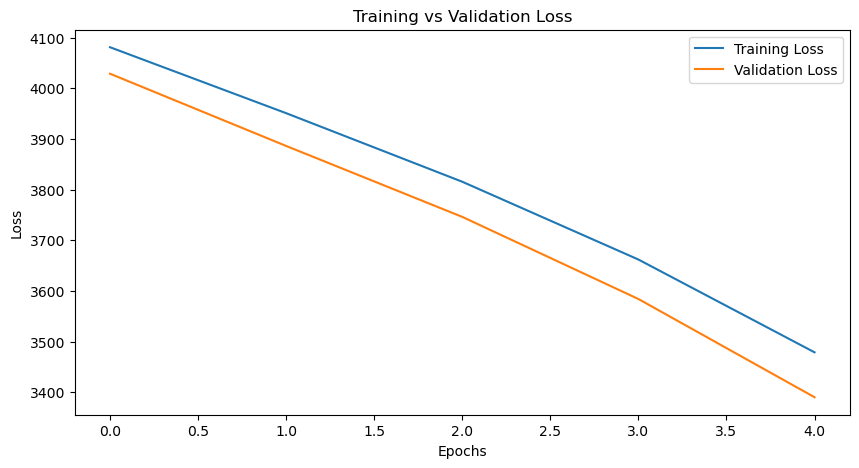

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
R² Score: -298.9463


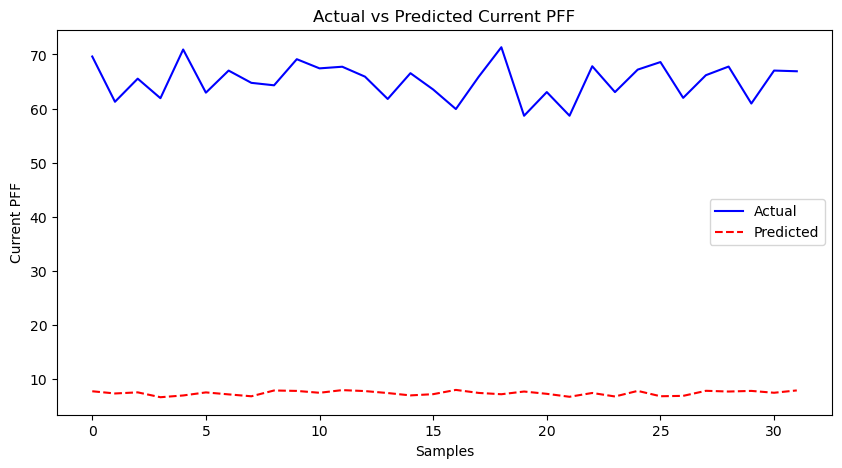

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3256.5635 - val_loss: 3153.6892
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3045.0798 - val_loss: 2866.6333
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2775.3840 - val_loss: 2521.2947
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2339.7661 - val_loss: 2115.4678
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1890.5947 - val_loss: 1656.1565
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1483.9919 - val_loss: 1148.4690
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1064.3878 - val_loss: 655.1237
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 578.9943 - val_loss: 255.5629
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 256.9658 - val_loss: 37.0276
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 72.8503 - val_loss: 19.8527


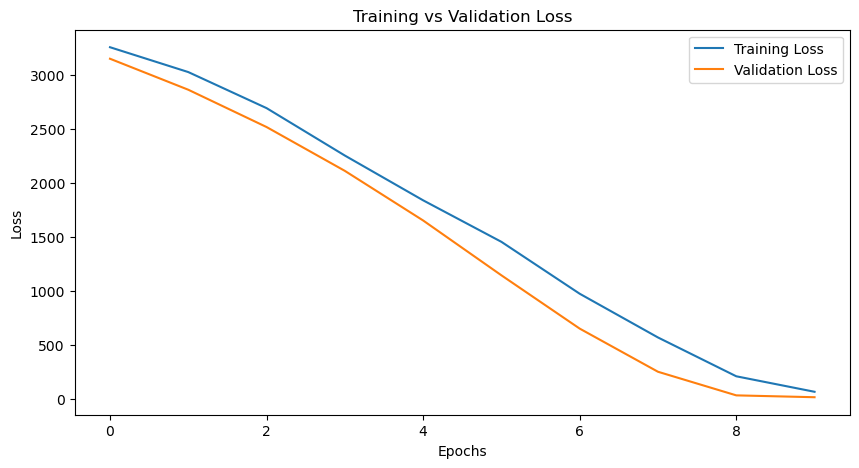

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -1.3748


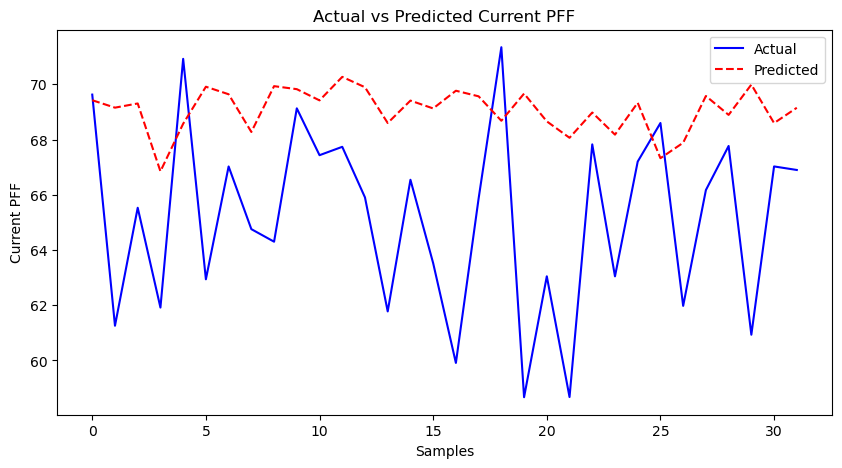

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 79.4456 - val_loss: 64.9748
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 136.9903 - val_loss: 82.9831
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 153.5394 - val_loss: 46.3032
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.5087 - val_loss: 19.7425
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 150.3607 - val_loss: 8.0085
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 85.8556 - val_loss: 11.6048
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.2885 - val_loss: 17.5370
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 87.4433 - val_loss: 11.1617
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.0417 - val_loss: 8.8891
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.6037 - val_loss: 8.6099
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.4974 - val_loss: 11.3334
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.9398 - val_los

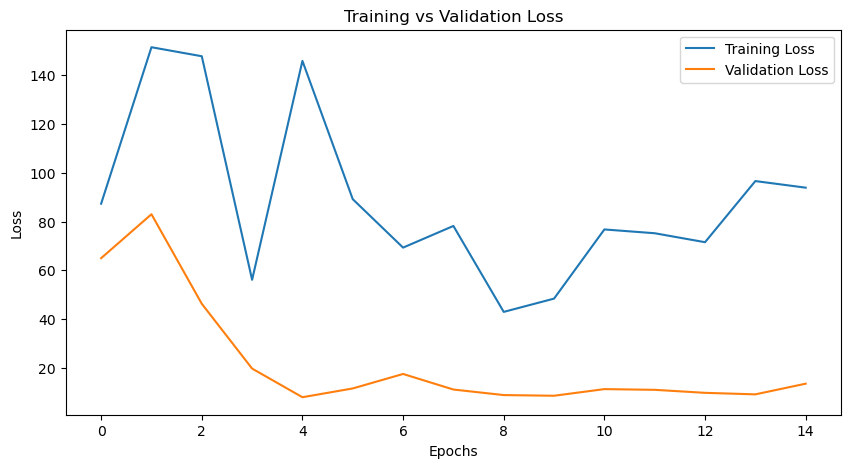

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -0.1812


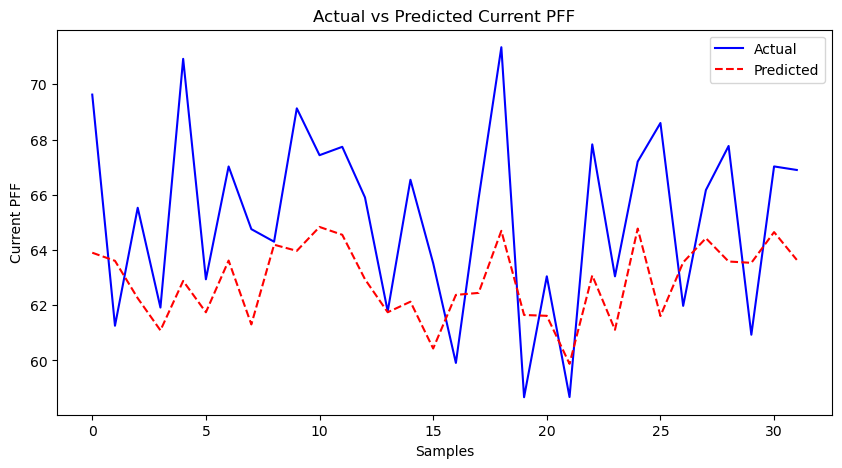

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 92.7872 - val_loss: 17.3052
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 93.2881 - val_loss: 14.1492
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.9191 - val_loss: 10.4402
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 116.6956 - val_loss: 9.8716
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78.9472 - val_loss: 10.0585
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59.2358 - val_loss: 10.1483
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.9336 - val_loss: 10.3116
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89.4996 - val_loss: 10.8256
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63.0410 - val_loss: 17.0570
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.1675 - val_loss: 19.6170
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.7544 - val_loss: 14.6810
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72.0151 - val_los

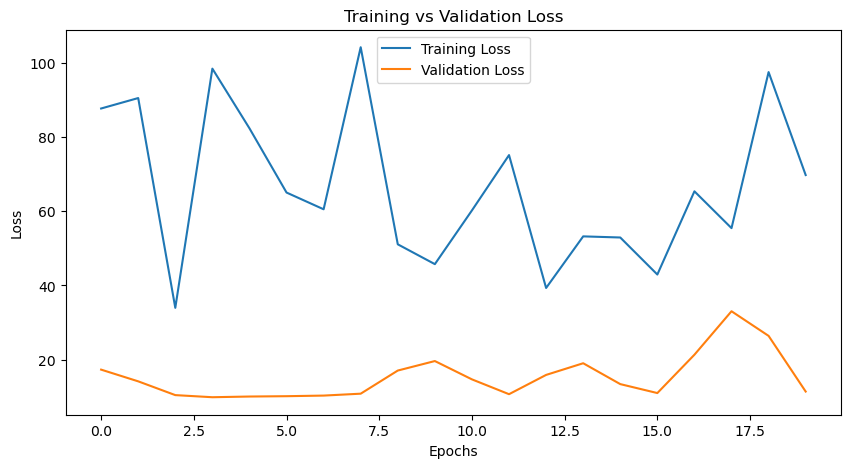

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.1922


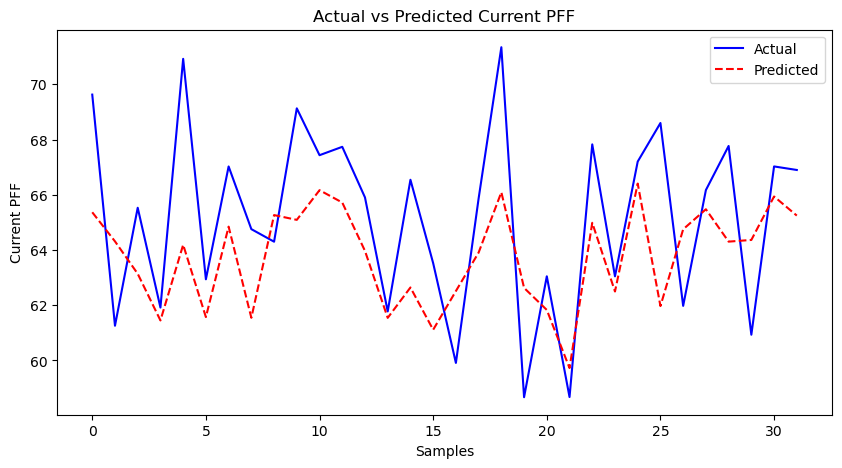

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 40.9313 - val_loss: 11.5550
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.4708 - val_loss: 12.2156
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 62.9430 - val_loss: 12.1613
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 108.6419 - val_loss: 15.1949
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 53.1371 - val_loss: 17.4952
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 107.1961 - val_loss: 12.0345
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.9844 - val_loss: 9.1956
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93.4962 - val_loss: 11.5143
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.3344 - val_loss: 10.7170
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78.8632 - val_loss: 8.6293
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 62.9349 - val_loss: 8.9994
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71.9345 - val_loss

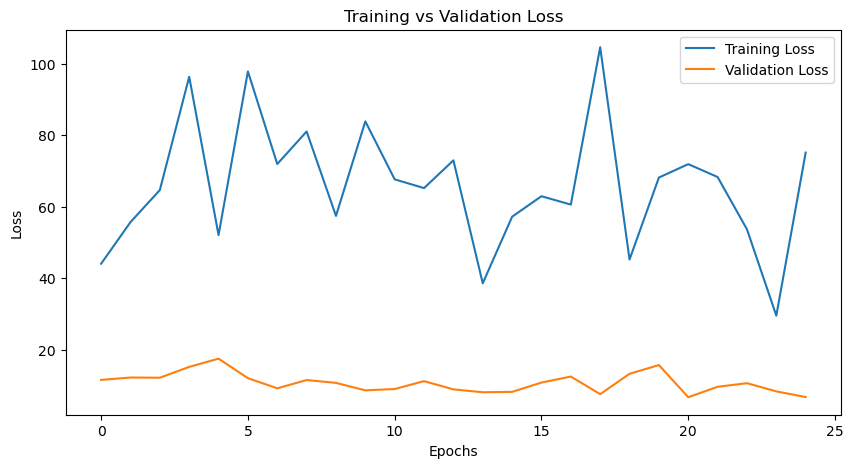

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
R² Score: 0.4763


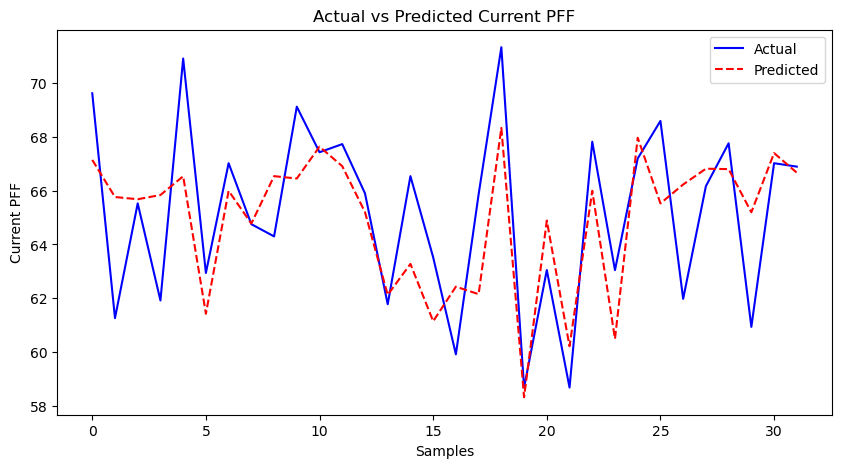

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 39.0688 - val_loss: 10.0957
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.2276 - val_loss: 7.4657
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.8411 - val_loss: 15.1480
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72.3909 - val_loss: 12.8163
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.9916 - val_loss: 9.1203
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.0546 - val_loss: 15.4541
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.6451 - val_loss: 19.0322
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.3526 - val_loss: 12.8665
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.8319 - val_loss: 10.0678
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.6330 - val_loss: 9.4901
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.1672 - val_loss: 9.9597
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.0369 - val_loss: 1

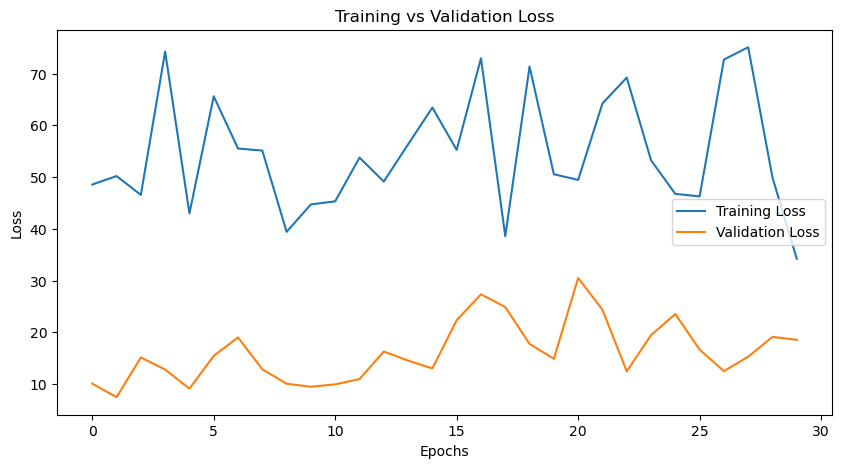

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.2086


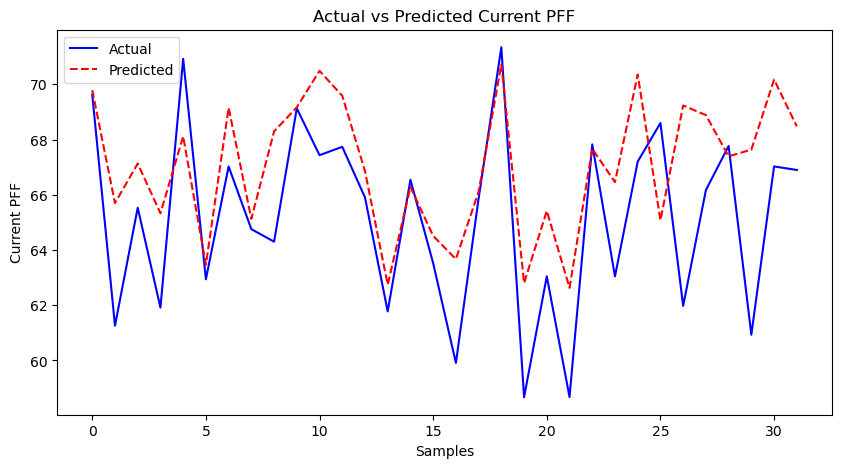

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 36.0050 - val_loss: 22.8088
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.5510 - val_loss: 21.6718
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.0626 - val_loss: 15.8005
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.2476 - val_loss: 15.1585
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80.0783 - val_loss: 16.2211
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.2729 - val_loss: 15.1794
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59.6369 - val_loss: 15.4036
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.7607 - val_loss: 16.3416
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.1854 - val_loss: 17.4483
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4786 - val_loss: 18.8824
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.5977 - val_loss: 18.1742
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 67.5701 - val_los

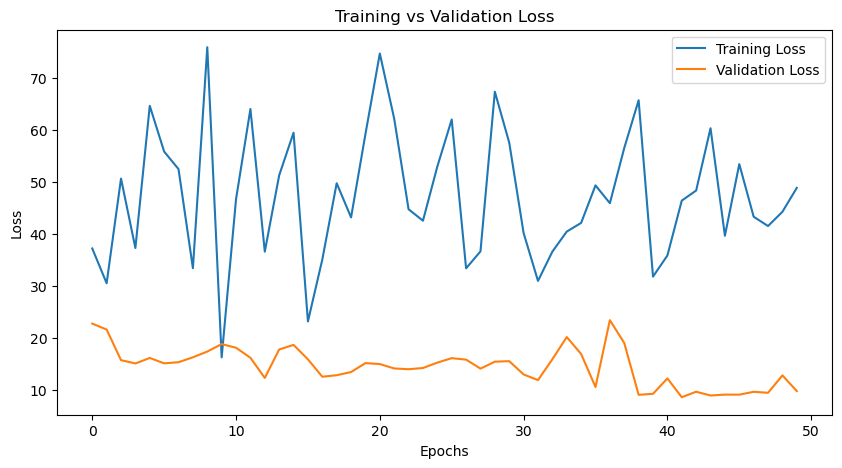

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score: 0.6116


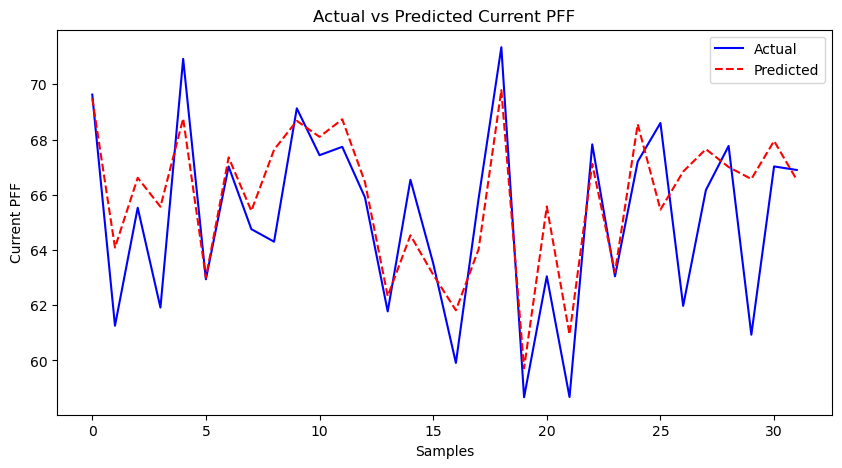

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 36.6798 - val_loss: 8.8799
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.0232 - val_loss: 8.7332
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.5615 - val_loss: 11.4947
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41.5556 - val_loss: 14.6809
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.4622 - val_loss: 13.3790
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66.4183 - val_loss: 12.0524
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.6421 - val_loss: 13.9136
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.2701 - val_loss: 11.8812
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 90.2948 - val_loss: 12.4212
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.0214 - val_loss: 13.6891
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.1455 - val_loss: 12.2858
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.8246

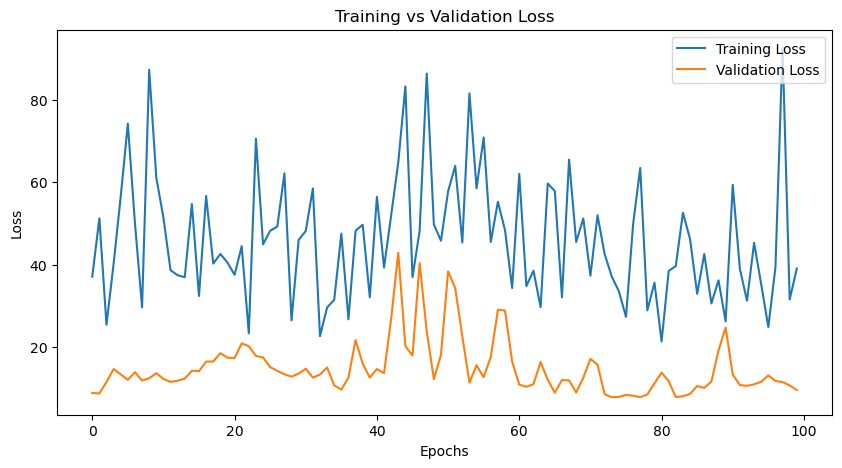

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.6168


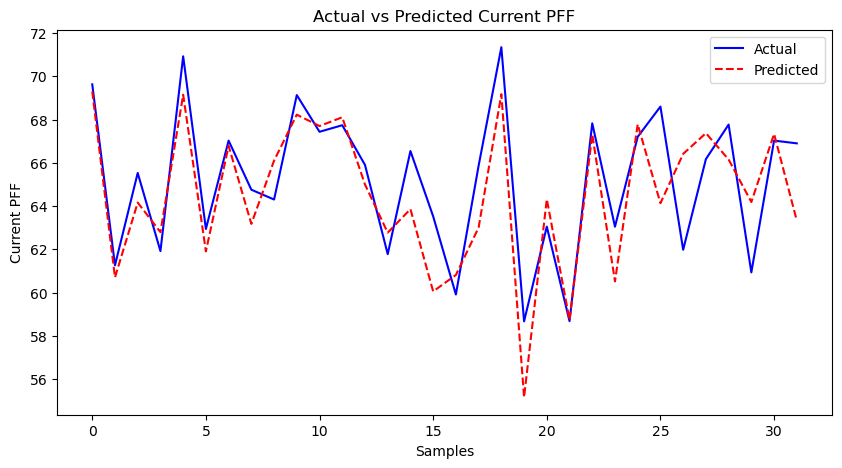

Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 32.5414 - val_loss: 9.8872
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.3355 - val_loss: 10.4278
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.1748 - val_loss: 9.4706
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.8653 - val_loss: 9.3826
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.4982 - val_loss: 9.2852
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.6385 - val_loss: 9.7944
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.4893 - val_loss: 9.2628
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.2586 - val_loss: 10.2876
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.5938 - val_loss: 9.5959
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.9845 - val_loss: 9.6878
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.9912 - val_loss: 10.6496
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.9841 - val

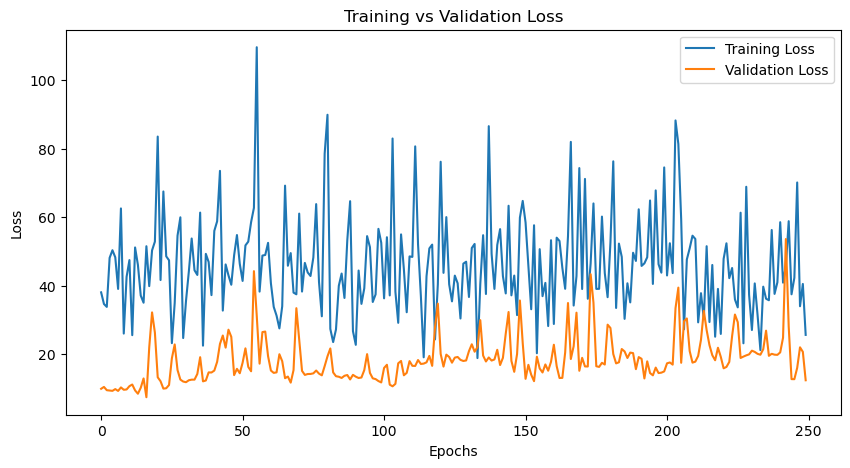

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
R² Score: 0.5367


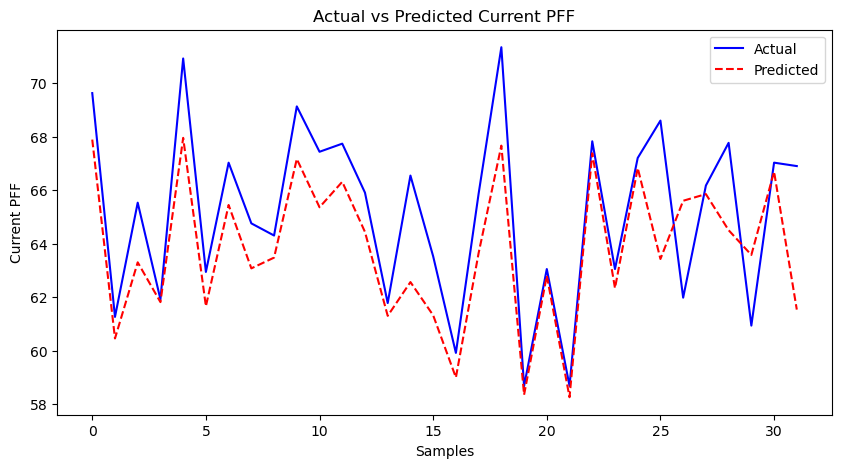

In [67]:
# Train the model
#history = model.fit(X, y, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stopping])
epoch_list = [5, 10, 15, 20, 25, 30, 50, 100, 250]
for e in epoch_list:
    history = model.fit(X, y, epochs=e, batch_size=8, validation_split=0.2)
    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Make predictions on the test set
    y_pred = model.predict(X)
    from sklearn.metrics import r2_score

    # Calculate R² score
    r2 = r2_score(y, y_pred)

    # Print R² score
    print(f"R² Score: {r2:.4f}")
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')
    plt.title('Actual vs Predicted Current PFF')
    plt.xlabel('Samples')
    plt.ylabel('Current PFF')
    plt.legend()
    plt.show()

In [68]:
# Import necessary libraries
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
# Function to prepare data sequences for a given target metric
def prepare_sequences(df, target_metric, sequence_length=3):
    sequences = []
    targets = []
    team_data = df.groupby('Team')

    for team, group in team_data:
        # Ensure the team has enough data
        if len(group) >= sequence_length + 1:
            # Iterate through the data to create sequences
            for i in range(len(group) - sequence_length):
                # Select the relevant columns for the sequence
                sequence = group.iloc[i:i+sequence_length][[
                    'Previous_grades_tackle', 
                    'Previous_AV',
                    'Previous_PFF',
                    'Previous_franchise_id',
                    'Previous_grades_run_defense',
                    'Previous_grades_coverage_defense',
                    'Previous_tackles_for_loss'
                ]]
                
                # The target is the next year's target_metric
                target = group.iloc[i+sequence_length][target_metric]
                
                sequences.append(sequence.values)
                targets.append(target)
    
    # Convert lists to numpy arrays
    X = np.array(sequences)
    y = np.array(targets)
    
    print(f"Total sequences generated for {target_metric}: {len(sequences)}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    
    # Reshape X to (samples, timesteps, features)
    X = X.reshape(X.shape[0], sequence_length, -1)
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    
    return X, y, scaler


In [70]:
# Function to build the model
def build_model(input_shape):
    inputs = Input(shape=input_shape)  # (timesteps, features)
    
    # Add a Dense layer before the attention to create more variability in the input
    dense_input = Dense(16, activation='relu')(inputs)
    
    # Add MultiHeadAttention layer
    attention_output = MultiHeadAttention(num_heads=2, key_dim=8)(dense_input, dense_input)
    
    # Add Layer Normalization for stability
    attention_output = LayerNormalization()(attention_output)
    
    # Add RNN layer to capture temporal dependencies
    rnn_output = SimpleRNN(units=50, activation='relu')(attention_output)
    
    # Add Dropout to prevent overfitting
    rnn_output = Dropout(0.2)(rnn_output)
    
    # Output layer for predicting the target metric
    output = Dense(1)(rnn_output)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [71]:
# Function to train and evaluate the model
def train_and_evaluate(X, y, target_metric, epochs_list, batch_size=8):
    input_shape = (X.shape[1], X.shape[2])  # (timesteps, features)
    model = build_model(input_shape)
    
    for e in epochs_list:
        print(f"\nTraining {target_metric} with {e} epochs...")
        history = model.fit(
            X, y, 
            epochs=e, 
            batch_size=batch_size, 
            validation_split=0.2, 
            verbose=1
        )
        
        # Plot training & validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training vs Validation Loss for {target_metric} - {e} Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        # Make predictions on the entire dataset (you might want to separate into train/test)
        y_pred = model.predict(X)
        
        # Calculate R² score
        r2 = r2_score(y, y_pred)
        print(f"R² Score for {target_metric} after {e} epochs: {r2:.4f}")
        
        # Plot actual vs predicted values
        plt.figure(figsize=(10, 5))
        plt.scatter(range(len(y)), y, label='Actual', color='blue', alpha=0.5)
        plt.scatter(range(len(y_pred)), y_pred, label='Predicted', color='red', alpha=0.5)
        plt.title(f'Actual vs Predicted {target_metric} after {e} Epochs')
        plt.xlabel('Samples')
        plt.ylabel(target_metric)
        plt.legend()
        plt.show()

First few rows of the DataFrame:
      Team  Year Position  Value_cap_space  Value_draft_data  Current_AV  \
17   49ers  2019       DB        15.313496        270.589442        35.0   
50   49ers  2020       DB        13.657921        257.525536        36.0   
70   49ers  2021       DB         7.895890        247.080988        34.0   
123  49ers  2022       DB        11.383285        101.033420        45.0   
12   Bears  2019       DB        19.373007        241.860963        43.0   

     Current_PFF Total DVOA  win-loss-pct  Net EPA  ...  \
17     74.600742     27.90%      0.812500    0.216  ...   
50     66.704119      5.40%      0.375000    0.025  ...   
70     62.219454     19.50%      0.588235    0.081  ...   
123    69.627066     27.60%      0.764706    0.196  ...   
12     66.382439     -2.10%      0.500000   -0.032  ...   

     Previous_snap_counts_slot  Previous_stops  Previous_tackles  \
17                  105.954181        8.742204         29.438840   
50                 

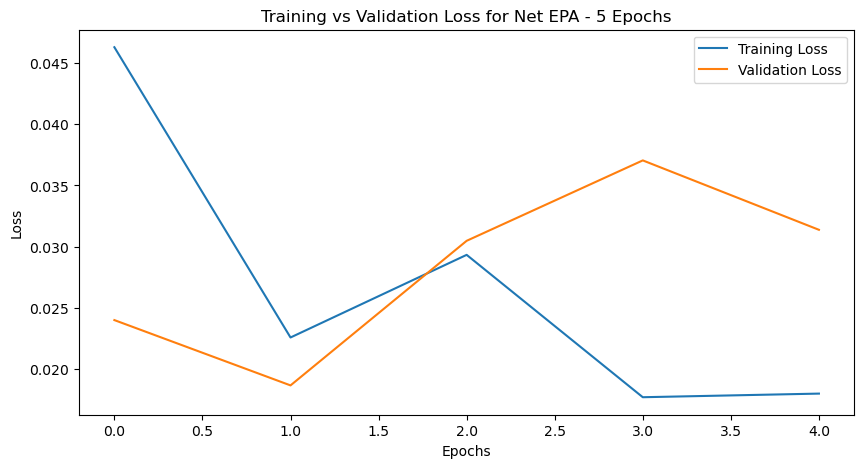

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
R² Score for Net EPA after 5 epochs: -0.5686
MAE for Net EPA after 5 epochs: 0.1263
RMSE for Net EPA after 5 epochs: 0.1367


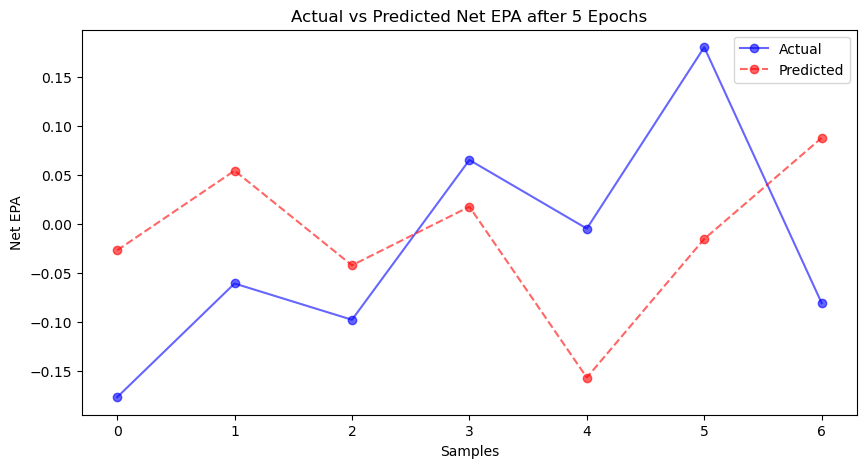


Training Net EPA with 10 epochs...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0211 - val_loss: 0.0208
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0244 - val_loss: 0.0278
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0211 - val_loss: 0.0298
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_loss: 0.0273
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - val_loss: 0.0267
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - val_loss: 0.0233
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0185
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0154
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0153
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0278 - val_loss: 0.0189


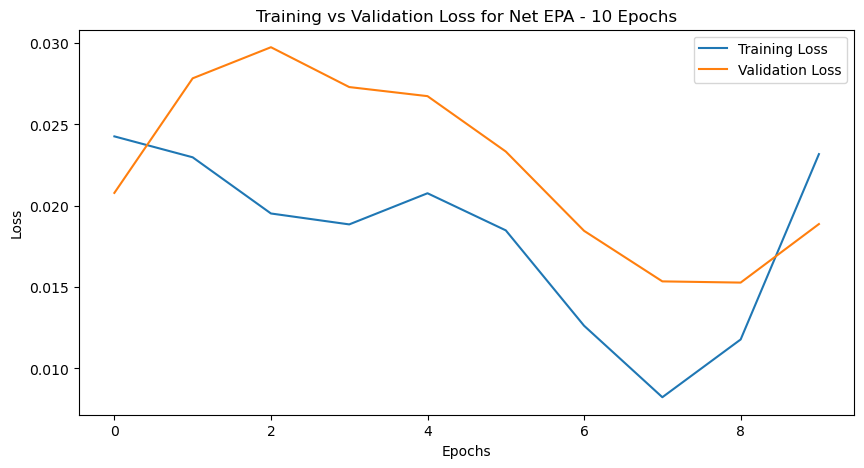

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Net EPA after 10 epochs: -0.2825
MAE for Net EPA after 10 epochs: 0.1082
RMSE for Net EPA after 10 epochs: 0.1236


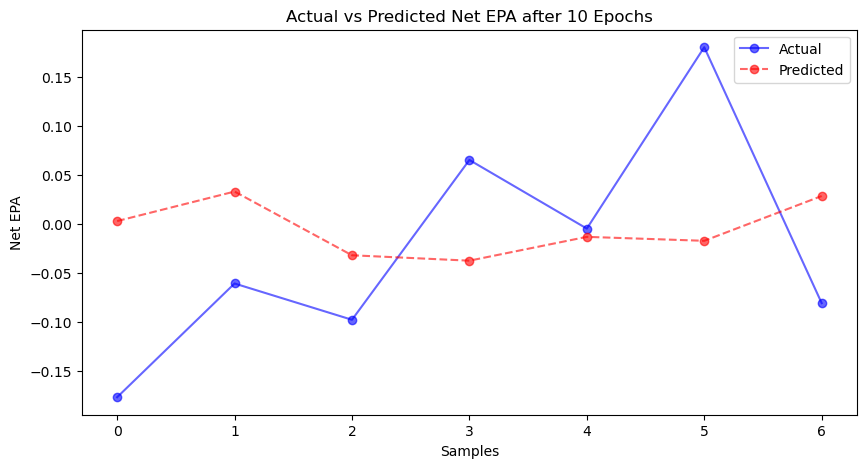


Training Net EPA with 15 epochs...
Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - val_loss: 0.0214
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0244
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0226
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0172
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0150
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0140
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0128
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - val_loss: 0.0123
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0147
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0178
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0212
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

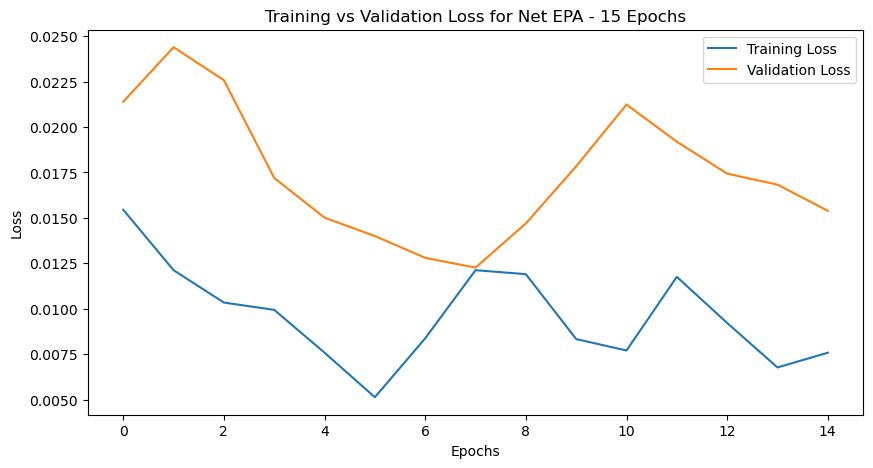

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Net EPA after 15 epochs: -0.0293
MAE for Net EPA after 15 epochs: 0.0998
RMSE for Net EPA after 15 epochs: 0.1107


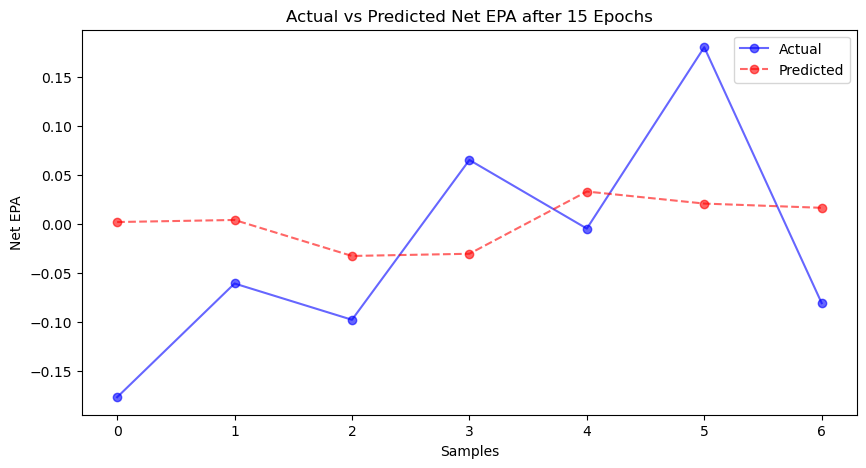


Training Net EPA with 20 epochs...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - val_loss: 0.0124
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0128
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0139
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0157
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0190
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_loss: 0.0208
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0188
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0172
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_loss: 0.0164
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0167
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0164
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

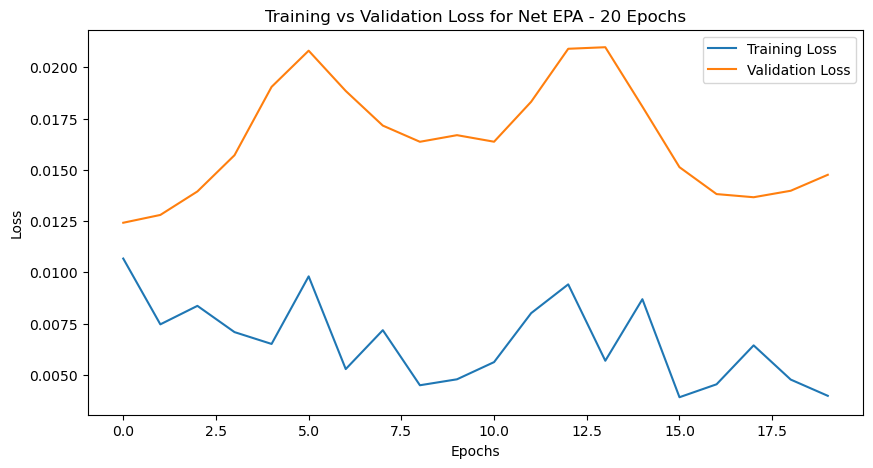

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Net EPA after 20 epochs: -0.0424
MAE for Net EPA after 20 epochs: 0.1021
RMSE for Net EPA after 20 epochs: 0.1114


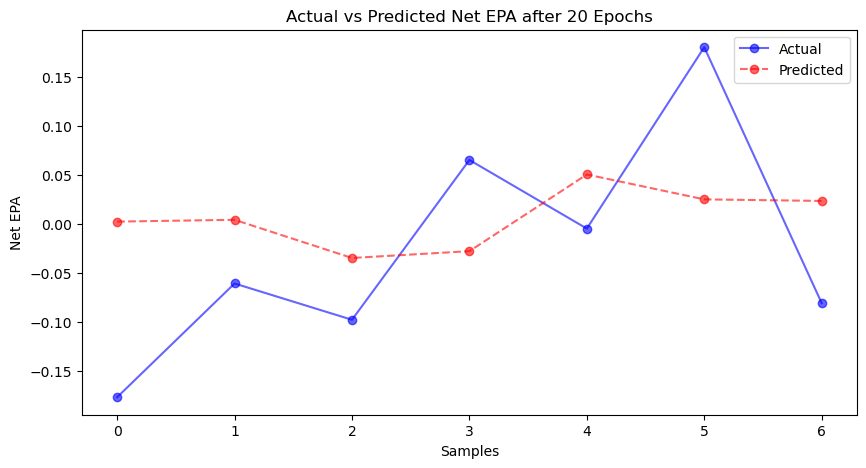


Training Net EPA with 25 epochs...
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 0.0139
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0179
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0251
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0236
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_loss: 0.0179
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0168
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0181
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0184
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0164
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0156
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0165
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

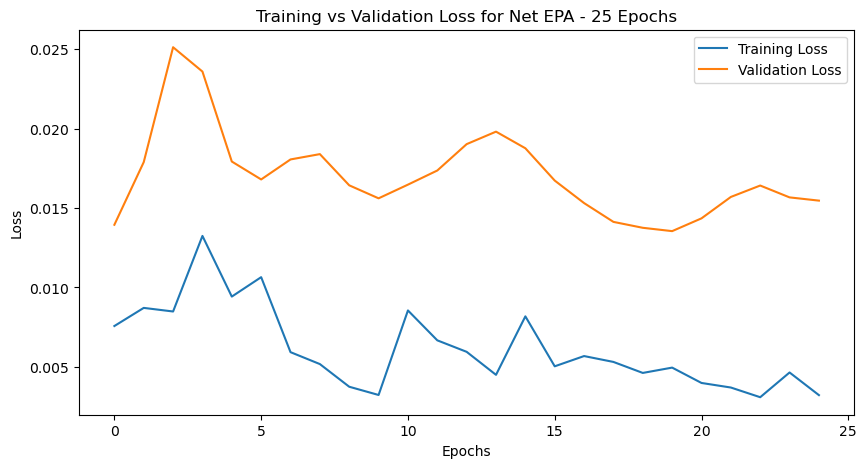

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Net EPA after 25 epochs: -0.1372
MAE for Net EPA after 25 epochs: 0.0966
RMSE for Net EPA after 25 epochs: 0.1164


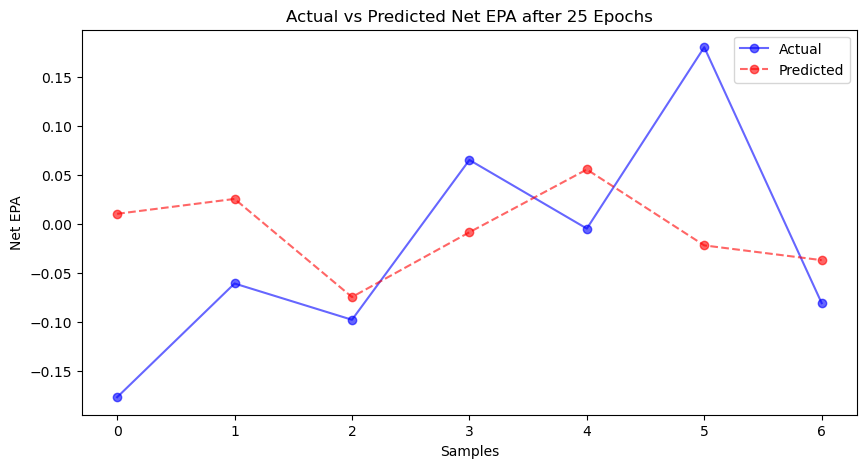


Training Net EPA with 30 epochs...
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - val_loss: 0.0146
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0151
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0160
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0164
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0166
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0169
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0171
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0192
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0185
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0156
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0155
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

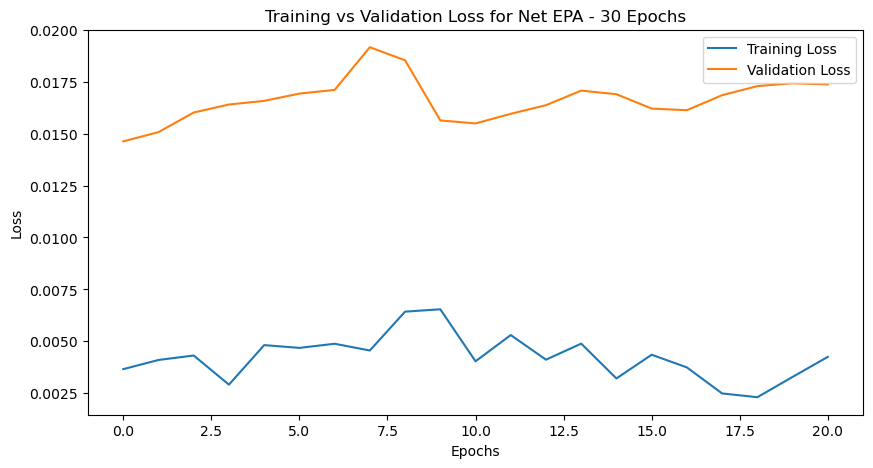

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R² Score for Net EPA after 30 epochs: -0.2278
MAE for Net EPA after 30 epochs: 0.1044
RMSE for Net EPA after 30 epochs: 0.1209


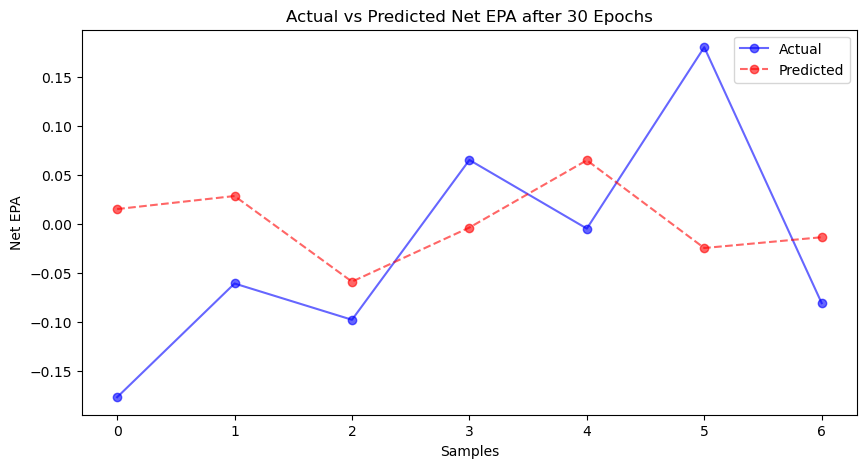


Training Net EPA with 50 epochs...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0149
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0164
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0186
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0192
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_loss: 0.0187
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0183
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0208
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0205
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0161
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0144
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_loss: 0.0148
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

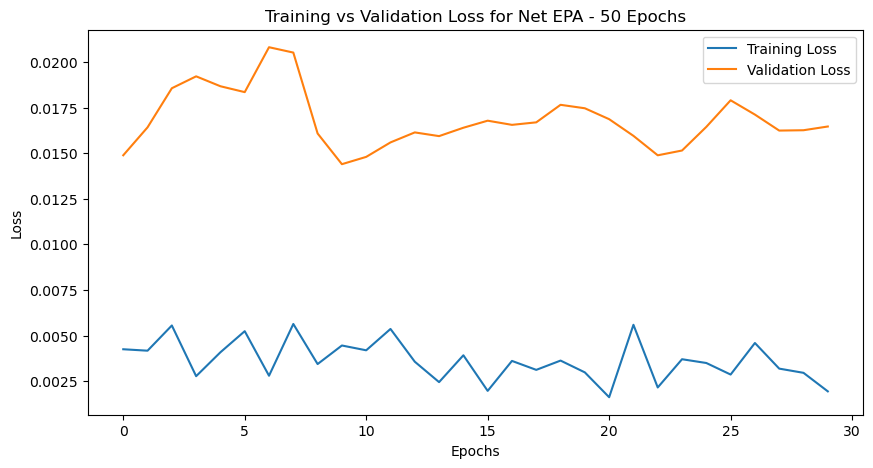

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Net EPA after 50 epochs: -0.2085
MAE for Net EPA after 50 epochs: 0.0983
RMSE for Net EPA after 50 epochs: 0.1200


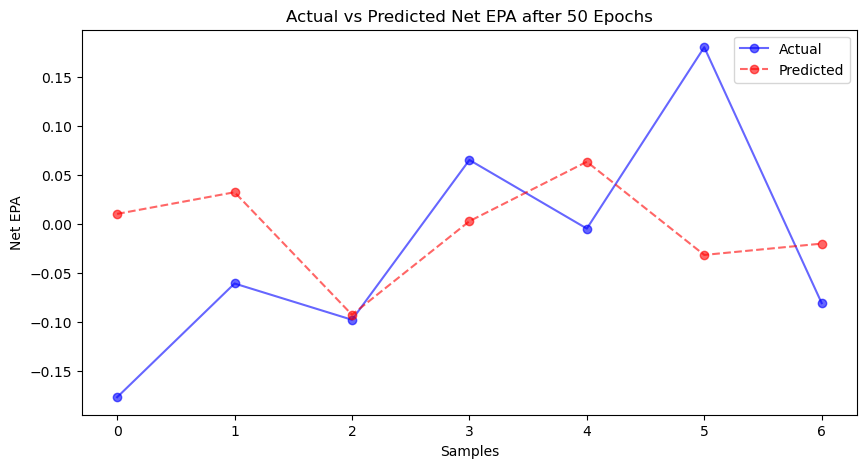


Training Net EPA with 100 epochs...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0150
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0169
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0187
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0172
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0149
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0146
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0151
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0165
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0173
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0165
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0163
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

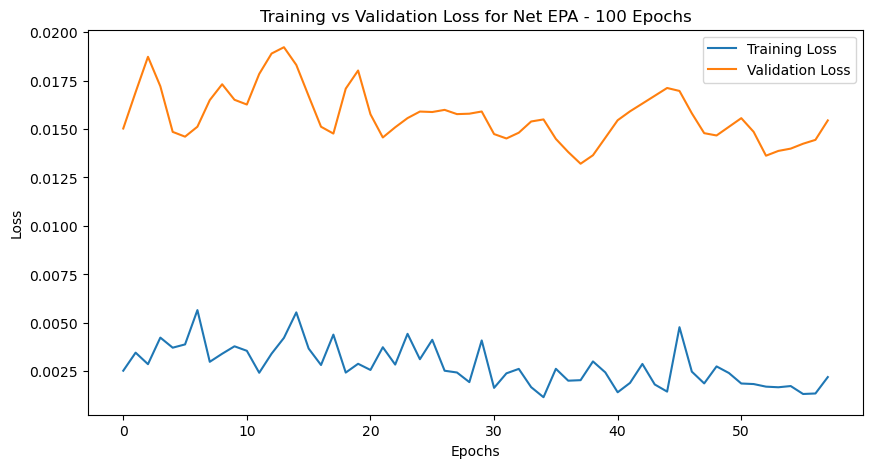

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² Score for Net EPA after 100 epochs: -0.1088
MAE for Net EPA after 100 epochs: 0.0974
RMSE for Net EPA after 100 epochs: 0.1149


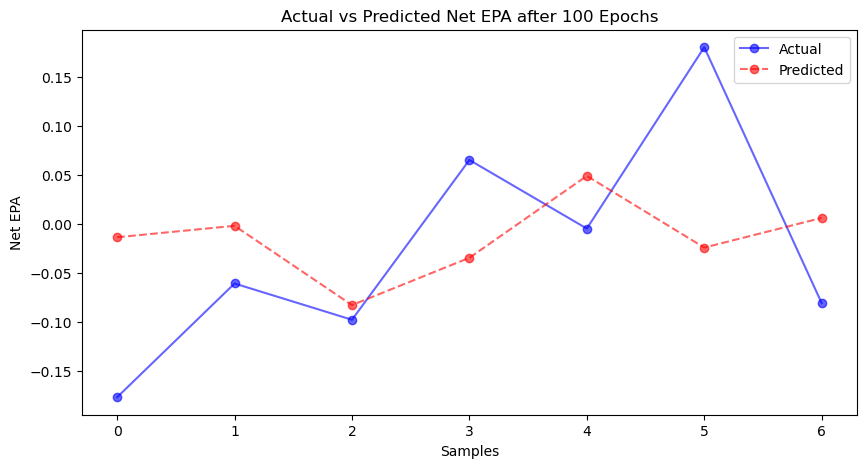


Training Net EPA with 250 epochs...
Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0148
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0156
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0155
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0167
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0177
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0179
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0177
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0179
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0173
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0157
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 0.0153
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

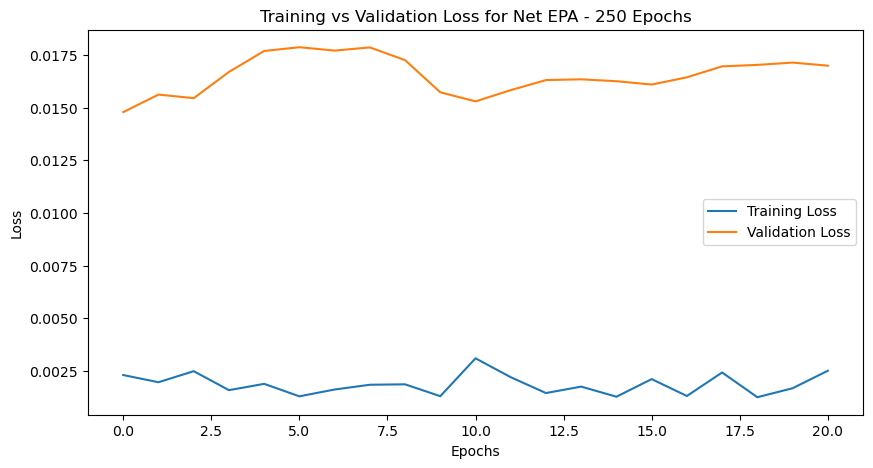

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R² Score for Net EPA after 250 epochs: -0.2417
MAE for Net EPA after 250 epochs: 0.1099
RMSE for Net EPA after 250 epochs: 0.1216


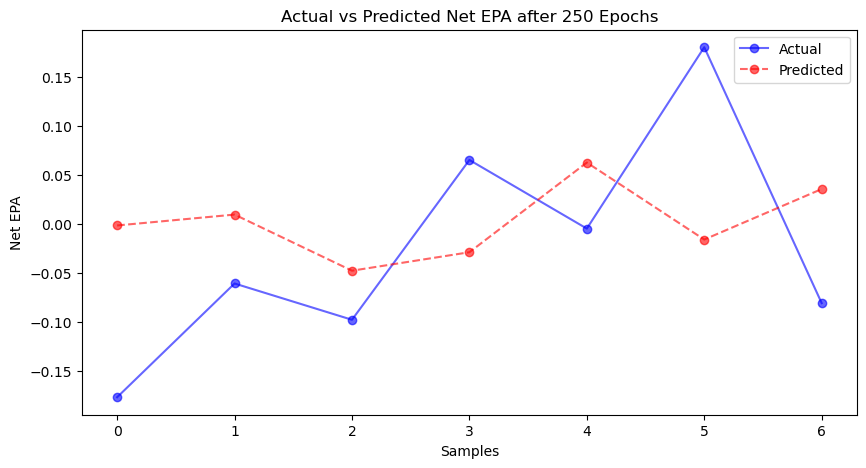


Preparing data for target metric: Total DVOA
Total sequences generated for Total DVOA: 32
X shape: (32, 3, 7), y shape: (32,)

Data Types in X_train: float64
Data Types in X_test: float64
Data Types in y_train: float64
Data Types in y_test: float64

Training Total DVOA with 5 epochs...
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0757 - val_loss: 0.0312
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0545 - val_loss: 0.0280
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0388 - val_loss: 0.0275
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0291 - val_loss: 0.0257
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - val_loss: 0.0223


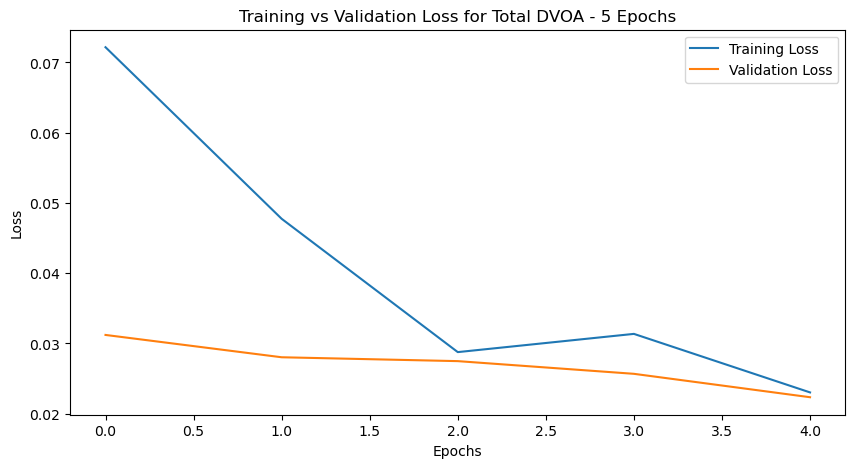

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
R² Score for Total DVOA after 5 epochs: -0.1288
MAE for Total DVOA after 5 epochs: 0.1130
RMSE for Total DVOA after 5 epochs: 0.1495


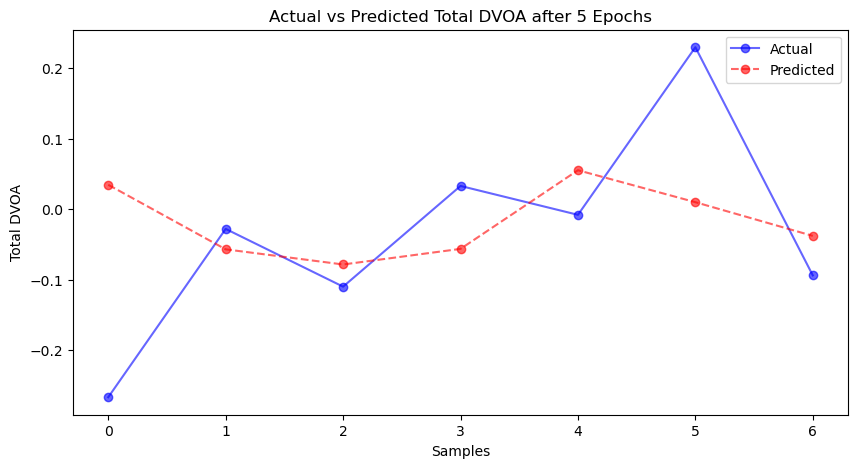


Training Total DVOA with 10 epochs...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0148 - val_loss: 0.0211
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - val_loss: 0.0213
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - val_loss: 0.0212
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252 - val_loss: 0.0219
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - val_loss: 0.0235
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 - val_loss: 0.0241
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - val_loss: 0.0236
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0217
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0208
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.0208


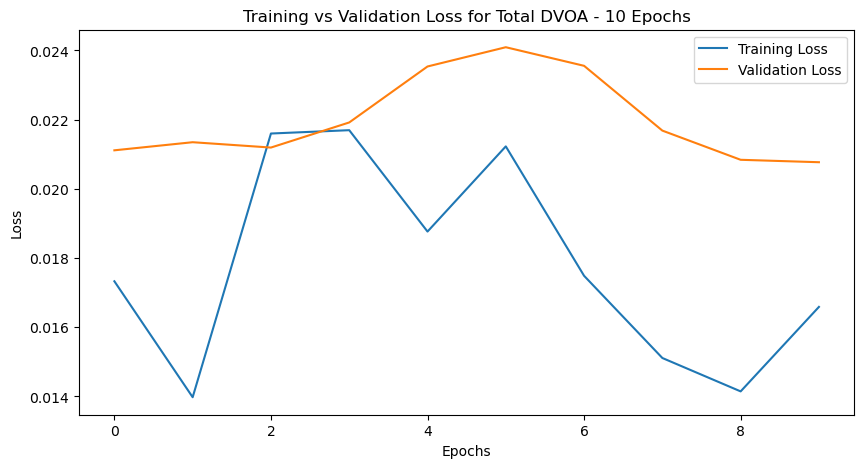

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Total DVOA after 10 epochs: -0.0493
MAE for Total DVOA after 10 epochs: 0.1077
RMSE for Total DVOA after 10 epochs: 0.1441


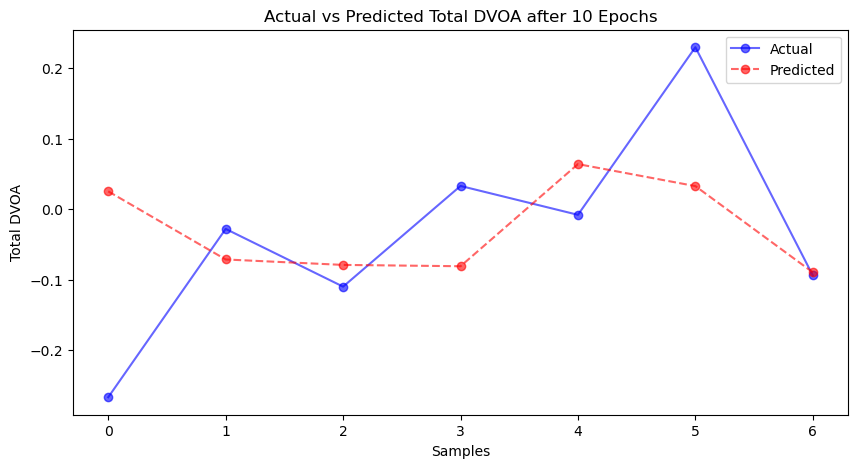


Training Total DVOA with 15 epochs...
Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0145 - val_loss: 0.0218
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - val_loss: 0.0236
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0230
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 - val_loss: 0.0223
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0235
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0268
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 - val_loss: 0.0285
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - val_loss: 0.0270
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143 - val_loss: 0.0255
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0244
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0220
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

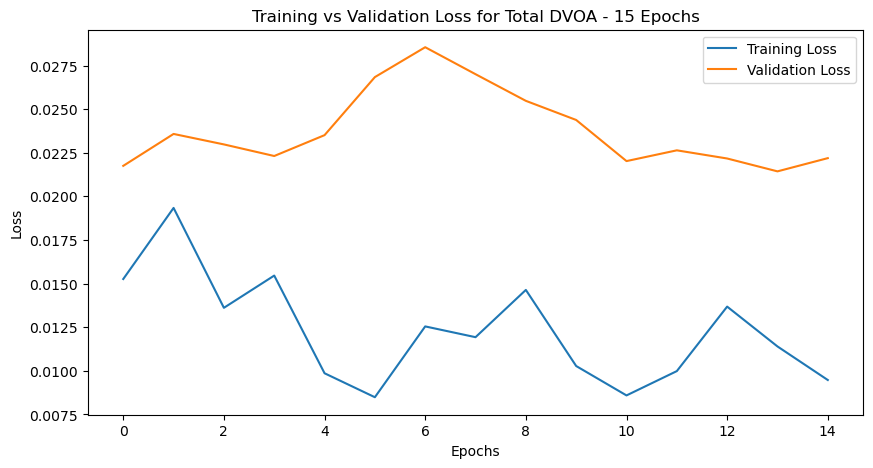

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Total DVOA after 15 epochs: -0.0829
MAE for Total DVOA after 15 epochs: 0.0924
RMSE for Total DVOA after 15 epochs: 0.1464


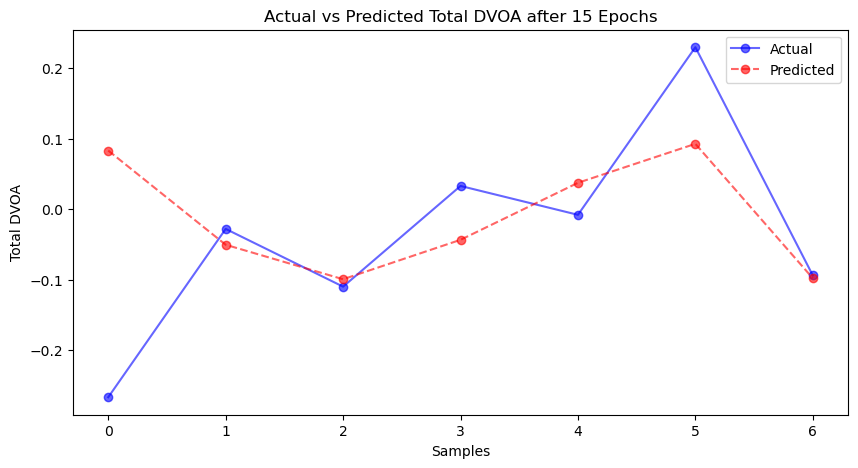


Training Total DVOA with 20 epochs...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - val_loss: 0.0219
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0225
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 0.0222
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0254
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - val_loss: 0.0263
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0255
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0250
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0253
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0264
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0268
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0274
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

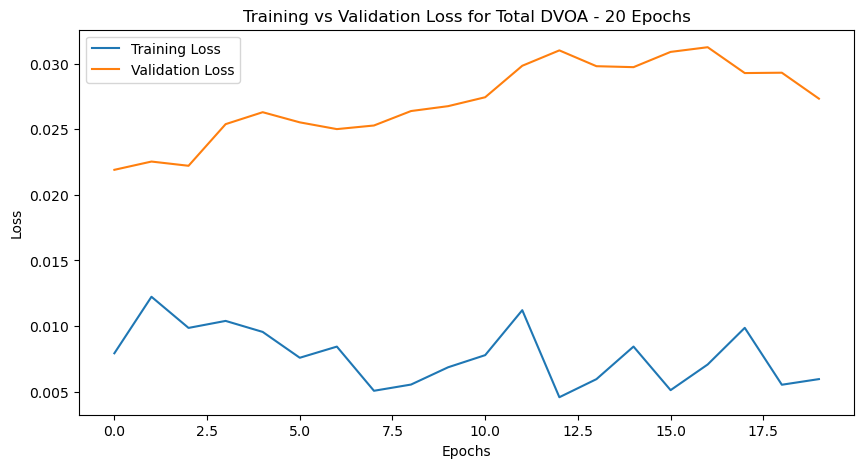

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score for Total DVOA after 20 epochs: -0.1069
MAE for Total DVOA after 20 epochs: 0.1054
RMSE for Total DVOA after 20 epochs: 0.1480


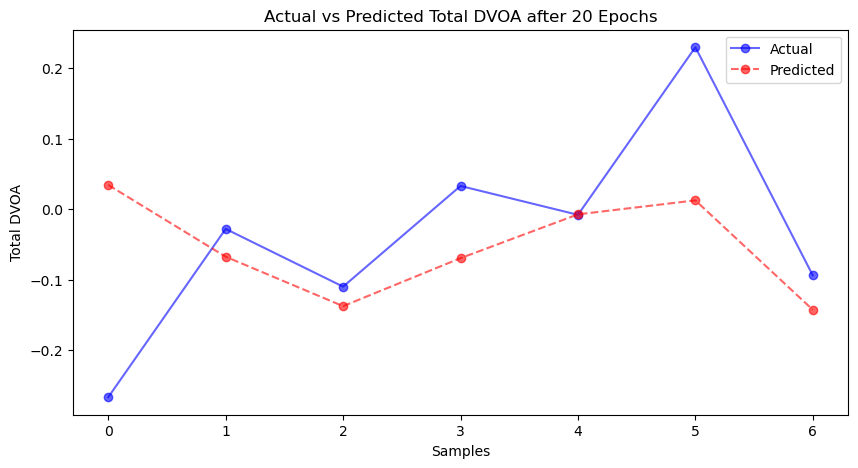


Training Total DVOA with 25 epochs...
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - val_loss: 0.0229
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0228
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0264
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 0.0264
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_loss: 0.0259
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0259
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0263
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0266
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0267
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0258
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 0.0260
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

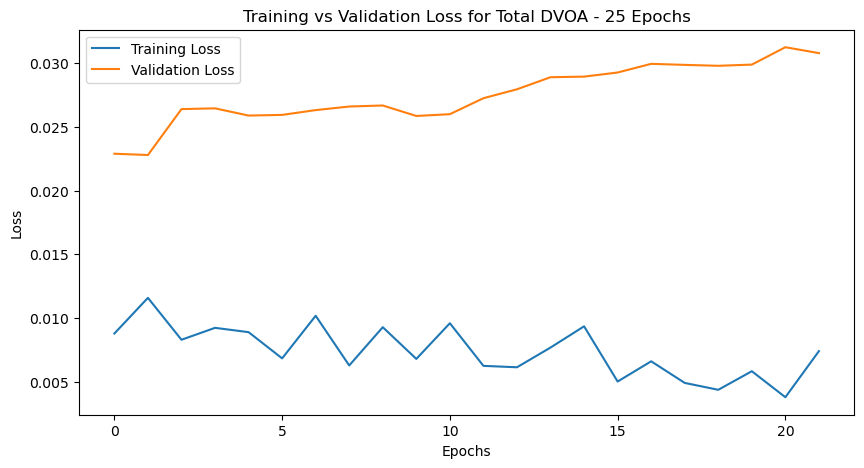

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² Score for Total DVOA after 25 epochs: -0.1510
MAE for Total DVOA after 25 epochs: 0.1038
RMSE for Total DVOA after 25 epochs: 0.1509


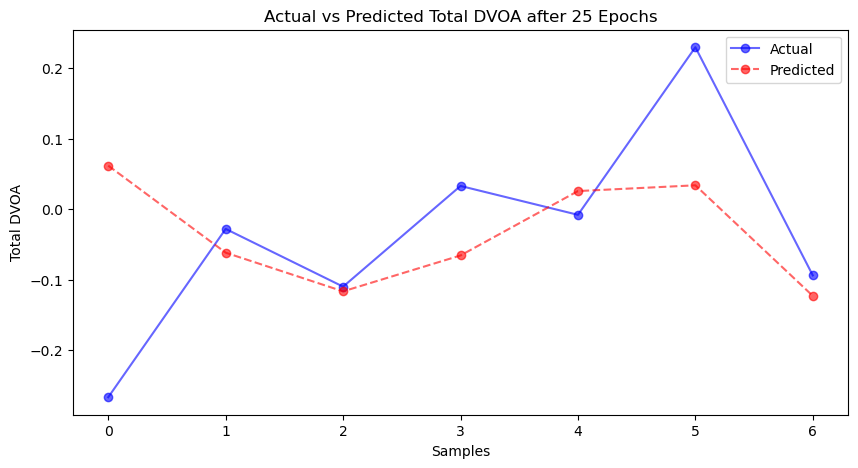


Training Total DVOA with 30 epochs...
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - val_loss: 0.0233
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0257
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0281
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_loss: 0.0287
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0284
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0285
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0276
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0272
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0270
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0264
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0270
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

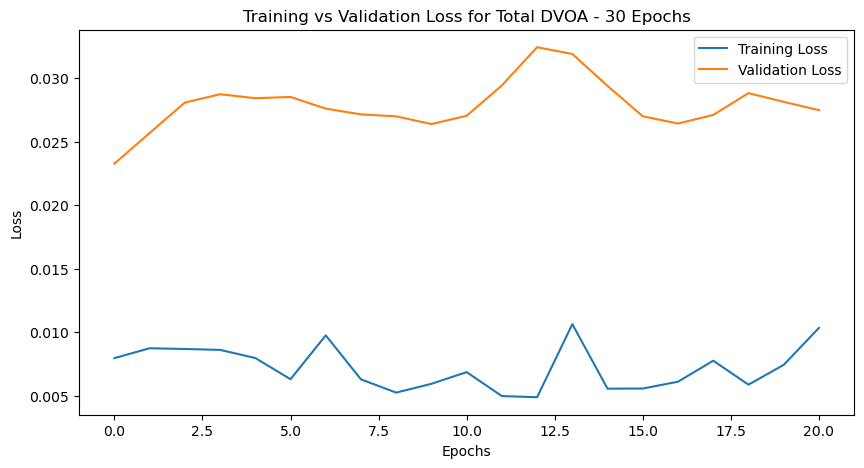

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Total DVOA after 30 epochs: -0.1754
MAE for Total DVOA after 30 epochs: 0.1014
RMSE for Total DVOA after 30 epochs: 0.1525


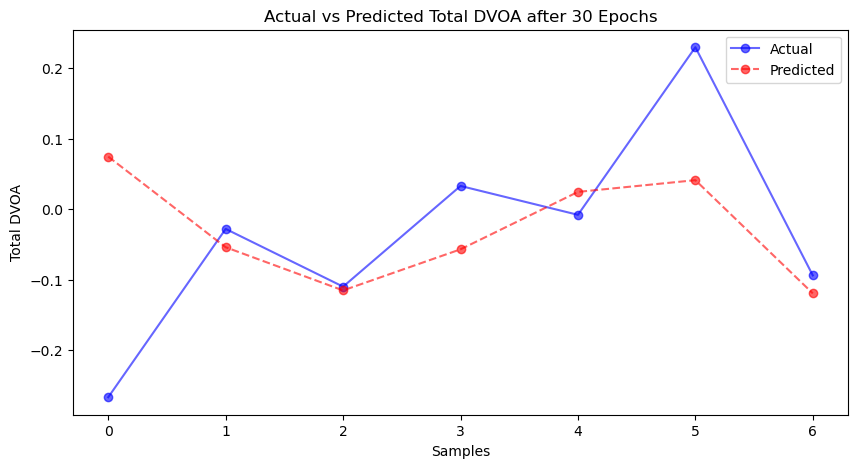


Training Total DVOA with 50 epochs...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - val_loss: 0.0246
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0249
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - val_loss: 0.0251
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0259
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0265
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0265
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0270
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0276
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0281
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0291
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0296
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

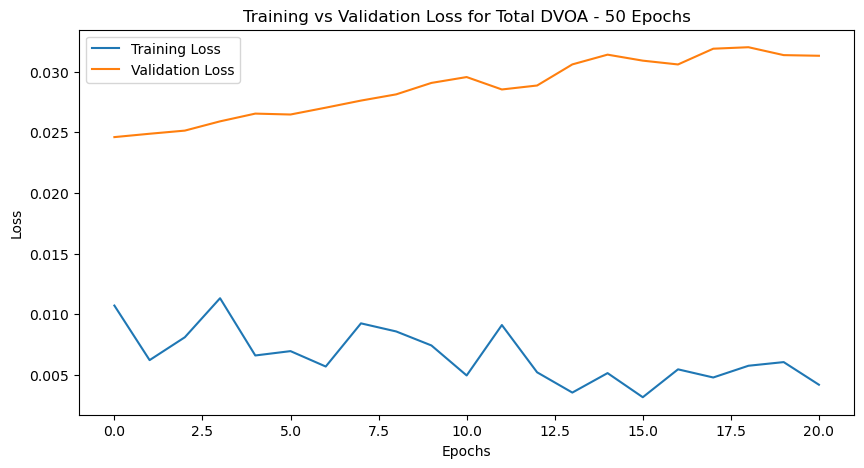

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Total DVOA after 50 epochs: -0.2431
MAE for Total DVOA after 50 epochs: 0.1068
RMSE for Total DVOA after 50 epochs: 0.1569


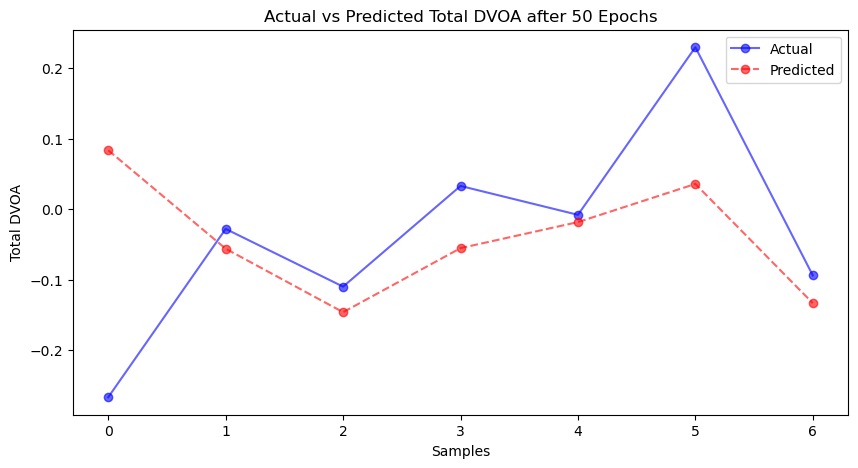


Training Total DVOA with 100 epochs...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - val_loss: 0.0249
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0242
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0246
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0246
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0241
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0246
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0262
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0297
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0298
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.0308
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - val_loss: 0.0318
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

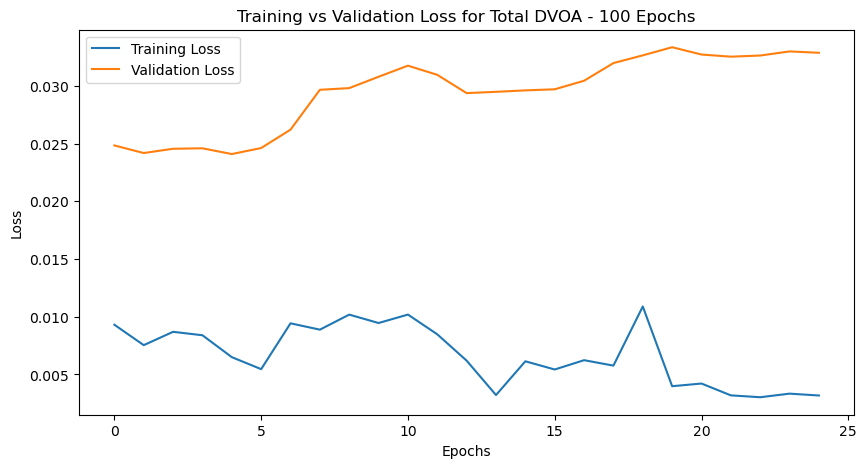

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score for Total DVOA after 100 epochs: -0.2177
MAE for Total DVOA after 100 epochs: 0.1087
RMSE for Total DVOA after 100 epochs: 0.1553


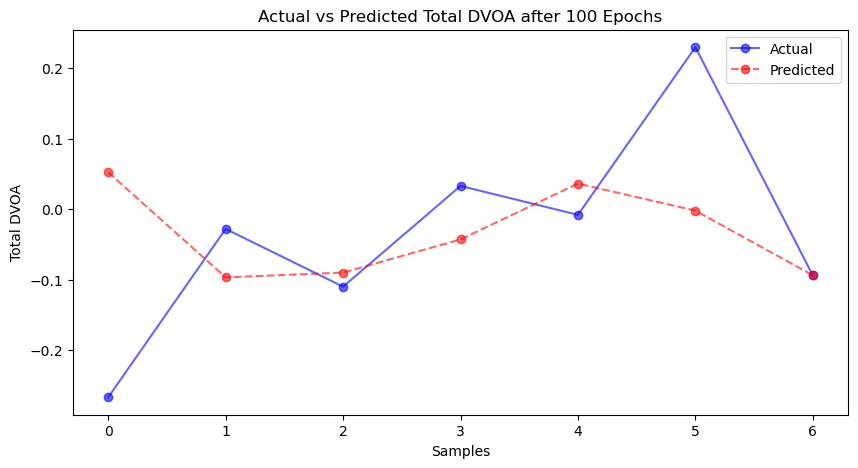


Training Total DVOA with 250 epochs...
Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - val_loss: 0.0240
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - val_loss: 0.0248
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0266
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0309
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_loss: 0.0320
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0301
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0297
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0300
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0308
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0310
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0301
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

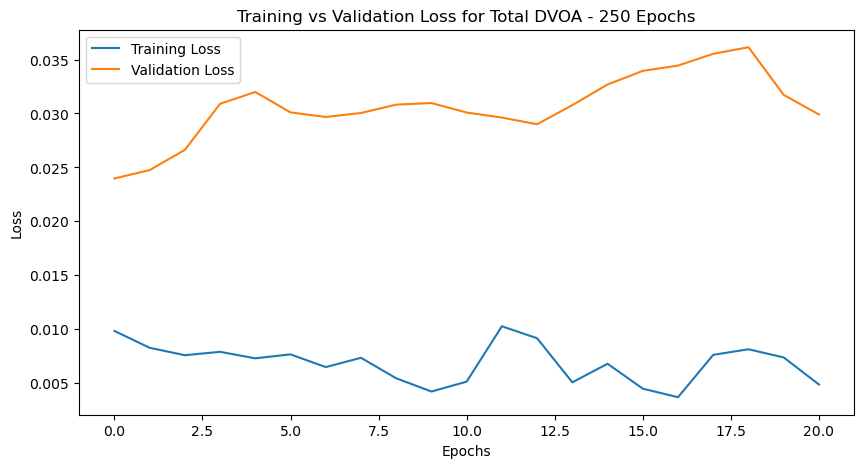

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R² Score for Total DVOA after 250 epochs: -0.2113
MAE for Total DVOA after 250 epochs: 0.1099
RMSE for Total DVOA after 250 epochs: 0.1548


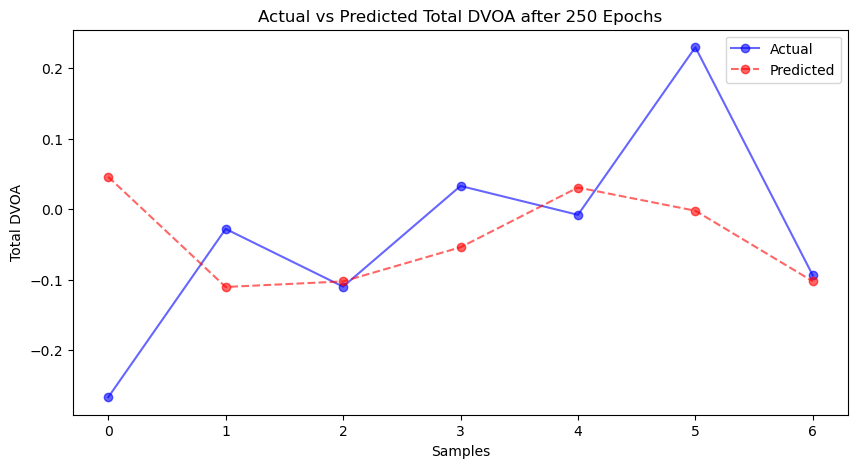

In [79]:
# Import necessary libraries
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer

# Function to clean percentage columns
def clean_percentage_column(df, column):
    # Remove '%' and convert to float, then divide by 100 if it's a percentage
    df[column] = df[column].str.replace('%', '').astype(float) / 100.0
    return df

# Function to prepare data sequences for a given target metric
def prepare_sequences(df, target_metric, feature_cols, sequence_length=3, test_size=0.2):
    sequences = []
    targets = []
    team_data = df.groupby('Team')

    for team, group in team_data:
        # Ensure the team has enough data
        if len(group) >= sequence_length + 1:
            # Iterate through the data to create sequences
            for i in range(len(group) - sequence_length):
                # Select the relevant columns for the sequence
                sequence = group.iloc[i:i+sequence_length][feature_cols]
                
                # The target is the next year's target_metric
                target = group.iloc[i+sequence_length][target_metric]
                
                sequences.append(sequence.values)
                targets.append(target)

    # Convert lists to numpy arrays
    X = np.array(sequences)
    y = np.array(targets)

    print(f"Total sequences generated for {target_metric}: {len(sequences)}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    # Reshape X to (samples, timesteps, features)
    X = X.reshape(X.shape[0], sequence_length, -1)

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test, scaler

# Function to build the model
def build_model(input_shape):
    inputs = Input(shape=input_shape)  # (timesteps, features)
    
    # Add a Dense layer before the attention to create more variability in the input
    dense_input = Dense(16, activation='relu')(inputs)
    
    # Add MultiHeadAttention layer
    attention_output = MultiHeadAttention(num_heads=2, key_dim=8)(dense_input, dense_input)
    
    # Add Layer Normalization for stability
    attention_output = LayerNormalization()(attention_output)
    
    # Add LSTM layer to capture temporal dependencies
    lstm_output = LSTM(units=50, activation='relu')(attention_output)
    
    # Add Dropout to prevent overfitting
    lstm_output = Dropout(0.2)(lstm_output)
    
    # Output layer for predicting the target metric
    output = Dense(1)(lstm_output)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test, target_metric, epochs_list, batch_size=8):
    input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
    model = build_model(input_shape)
    
    # Debugging: Check data types
    print("\nData Types in X_train:", X_train.dtype)
    print("Data Types in X_test:", X_test.dtype)
    print("Data Types in y_train:", y_train.dtype)
    print("Data Types in y_test:", y_test.dtype)
    
    # Check for any non-numeric data
    if not np.issubdtype(X_train.dtype, np.number):
        raise ValueError("X_train contains non-numeric data.")
    if not np.issubdtype(X_test.dtype, np.number):
        raise ValueError("X_test contains non-numeric data.")
    if not np.issubdtype(y_train.dtype, np.number):
        raise ValueError("y_train contains non-numeric data.")
    if not np.issubdtype(y_test.dtype, np.number):
        raise ValueError("y_test contains non-numeric data.")
    
    for e in epochs_list:
        print(f"\nTraining {target_metric} with {e} epochs...")
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        history = model.fit(
            X_train, y_train, 
            epochs=e, 
            batch_size=batch_size, 
            validation_data=(X_test, y_test), 
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Plot training & validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training vs Validation Loss for {target_metric} - {e} Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate evaluation metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"R² Score for {target_metric} after {e} epochs: {r2:.4f}")
        print(f"MAE for {target_metric} after {e} epochs: {mae:.4f}")
        print(f"RMSE for {target_metric} after {e} epochs: {rmse:.4f}")
        
        # Plot actual vs predicted values with lines
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(y_test)), y_test, label='Actual', color='blue', linestyle='-', marker='o', alpha=0.6)
        plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='red', linestyle='--', marker='o', alpha=0.6)
        plt.title(f'Actual vs Predicted {target_metric} after {e} Epochs')
        plt.xlabel('Samples')
        plt.ylabel(target_metric)
        plt.legend()
        plt.show()


# Main Execution
if __name__ == "__main__":
    # Load the data
    df = pd.read_csv('Combined_Secondary_Defense.csv')
    
    # Define the intended target metrics with correct column names
    intended_target_metrics = ['Net EPA', 'Total DVOA']  # Corrected target metrics
    
    # Drop unnecessary columns
    columns_to_drop = ['Unnamed: 0']
    df = df.drop(columns=columns_to_drop, errors='ignore')  # Use errors='ignore' to avoid issues if the column doesn't exist
    
    # Sort data by Team and Year
    df = df.sort_values(by=['Team', 'Year'])
    print("First few rows of the DataFrame:")
    print(df.head())
    
    # Get the actual columns present
    actual_columns = df.columns.tolist()
    
    # Filter target metrics to include only existing columns
    target_metrics = [metric for metric in intended_target_metrics if metric in actual_columns]
    
    # Notify the user about missing columns
    missing_metrics = [metric for metric in intended_target_metrics if metric not in actual_columns]
    if missing_metrics:
        print(f"Warning: The following target metrics are missing in the DataFrame and will be skipped: {missing_metrics}")
    
    # Encode 'Previous_franchise_id' if it exists
    if 'Previous_franchise_id' in actual_columns:
        print("Encoding 'Previous_franchise_id'...")
        label_encoder = LabelEncoder()
        df['Previous_franchise_id_encoded'] = label_encoder.fit_transform(df['Previous_franchise_id'])
        print("Encoding completed.")
    else:
        print("Warning: 'Previous_franchise_id' column is missing from the DataFrame.")
    
    # Update actual_columns after encoding
    actual_columns = df.columns.tolist()
    
    # Define feature columns with encoded 'Previous_franchise_id'
    feature_columns = [
        'Previous_grades_tackle', 
        'Previous_AV',
        'Previous_PFF',
        'Previous_franchise_id_encoded',  # Use the encoded column
        'Previous_grades_run_defense',
        'Previous_grades_coverage_defense',
        'Previous_tackles_for_loss'
    ]
    
    # Check if all feature columns exist
    missing_features = [feature for feature in feature_columns if feature not in actual_columns]
    if missing_features:
        print(f"Error: The following feature columns are missing in the DataFrame: {missing_features}")
        raise ValueError("Missing feature columns. Please verify your DataFrame.")
    
    # Verify that all feature columns are numeric
    print("\nVerifying that all feature columns are numeric...")
    non_numeric_features = df[feature_columns].select_dtypes(include=['object']).columns.tolist()
    if non_numeric_features:
        print(f"Error: The following feature columns contain non-numeric data: {non_numeric_features}")
        raise ValueError("Non-numeric data found in feature columns. Please encode or convert them to numeric types.")
    else:
        print("All feature columns are numeric.")
    
    # Check and handle non-numeric entries in feature columns
    print("\nChecking for non-numeric entries in feature columns...")
    for col in feature_columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"Converted '{col}' to numeric. Non-convertible values are set to NaN.")
    
    # Check for NaN values in feature and target columns
    print("\nChecking for NaN values in feature and target columns...")
    nan_counts = df[feature_columns + target_metrics].isnull().sum()
    print(nan_counts)
    
    # Handle NaN values in target metrics by cleaning percentage strings and converting to numeric
    for metric in target_metrics:
        if df[metric].dtype == 'object':
            # Check if the column contains '%'
            if df[metric].str.contains('%').any():
                print(f"\nCleaning percentage values in '{metric}'...")
                df = clean_percentage_column(df, metric)
                print(f"'{metric}' cleaned.")
            else:
                # Attempt to convert to numeric, coercing errors to NaN
                df[metric] = pd.to_numeric(df[metric], errors='coerce')
                print(f"Converted '{metric}' to numeric.")
    
    # Check for NaN values again after cleaning target metrics
    print("\nChecking for NaN values in target metrics after cleaning:")
    print(df[target_metrics].isnull().sum())
    
    # Drop rows with NaN in target metrics
    df_clean = df.dropna(subset=target_metrics)
    print(f"\nNumber of rows after dropping NaN in target metrics: {df_clean.shape[0]}")
    
    # Initialize the imputer with a strategy (e.g., mean)
    imputer = SimpleImputer(strategy='mean')
    
    # Fit and transform the feature columns
    df_clean[feature_columns] = imputer.fit_transform(df_clean[feature_columns])
    
    # Verify that there are no NaNs left in feature columns
    print("\nNumber of NaN values in feature columns after imputation:")
    print(df_clean[feature_columns].isnull().sum())
    
    # Convert X_train, X_test, y_train, y_test to appropriate data types
    # This is already handled in the prepare_sequences function
    
    # Iterate over each valid target metric
    for metric in target_metrics:
        print(f"\nPreparing data for target metric: {metric}")
        X_train, X_test, y_train, y_test, scaler = prepare_sequences(df_clean, metric, feature_columns)
        
        # Define the list of epochs you want to train for
        epoch_list = [5, 10, 15, 20, 25, 30, 50, 100, 250]
        
        # Train and evaluate the model
        train_and_evaluate(X_train, X_test, y_train, y_test, metric, epoch_list)
